#### 데이터 전처리
1초단위로 100Mhz 단위로 샘플링된 데이터들을 전처리하는 단계로, 다음과 같은 기능을 수행함.
1) 데이터를 plot을 통해 확인
2) 모델에 적용시키기 위한 timestep으로 분할
3) .mat파일 외에 다른 형태로 파일을 저장하여 여러환경에서 사용할 수 있도록 파일을 저장


##### 라이브러리 로드
- `os`
    - python을 활용하여, system에 접근할 수 있도록 해주는 라이브러리
- `numpy`
    - 배열들이나 행렬연산 기능을 모아 놓은 라이브러리
- `scipy`
    - 통계적 연산, 공학연산 관련 기능을 모아 놓은 라이브러리
- `matplotlib`
    - 데이터 시각화에 쓰이는 기능들을 모아 놓은 라이브러리

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


##### 데이터 로드
데이터를 로드한 이후, ploting을 통해 데이터들의 경향성, 결측치 값을 확인한다.  
`.mat`파일을 로드한 경우, `dictionary` type으로 파일이 로드되고, `daq_data` key로 접근하면 데이터를 확인할 수 있다. python의 경우 `float`와 `double`이 서로 구분되지 않고, `float`로 모두 처리됨으로, 따로 데이터 타입을 지정하지 않아도 된다. 파일이 1초간격으로 저장되어 있기 때문에, 전체적인 분석을 위해서는 파일을 모두 불러와 하나의 `numpy.array` 형태로 정리한 후에 분석을 진행하였다.  

```python
# mat 파일 로드
import os
from scipy.io import loadmat
data = loadmat(os.path.join(path, file_name))
```

Text(0.5, 0, 'The number of data')

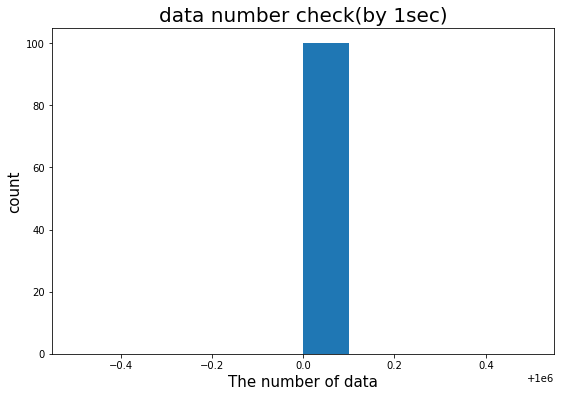

In [2]:
# Variables
path = './data'

# Load data
file_list = os.listdir(path)

# variables
data_len = np.array([])
data_all = np.empty((0, 1000000))

"""__summary__
raw_data = loadmat(os.path.join(path, file_list[0]))
a, b = raw_data['daq_data'].shape
data_all = np.empty((0, a))
"""

for file_name in file_list:
    raw_data = loadmat(os.path.join(path, file_name))
    temp_data = raw_data['daq_data'].T
    data_all = np.append(data_all, temp_data, axis=0)
    data_len = np.append(data_len, len(temp_data.reshape(-1)))

plt.figure(figsize=(9, 6))
plt.hist(data_len)
plt.title("data number check(by 1sec)", fontsize=20)
plt.ylabel("count", fontsize=15)
plt.xlabel("The number of data", fontsize=15)

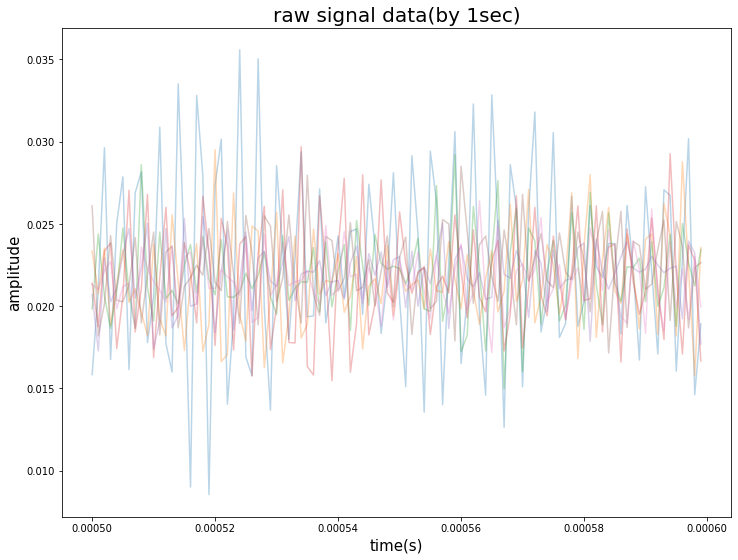

In [3]:
fs = 1e6 # Sampling Frequency
sr = 1/fs # Sampling rate

a=500 # data를 볼 시작 위치
b=600 # data를 볼 마지막 위치

time_interval = np.arange(0, 1, sr) # 100mhz로 1초를 나누어 time interval을 구함

# 데이터 ploting
plt.figure(figsize=(12,9))
for i in range(0, 7):
    plt.plot(time_interval[a:b], data_all[i][a:b], alpha=0.3)

plt.title("raw signal data(by 1sec)", fontsize=20)
plt.ylabel("amplitude", fontsize=15)
plt.xlabel("time(s)", fontsize=15)

plt.show()
"""
for data in data_all:
    plt.plot(time_interval, data, alpha=0.1)
"""
plt.show()

##### FFT
하드웨어 밴드패스 필터를 통과한 신호들을 FFT를 통해 원하는 주파수 정보들이 잘 들어왔는지 확인하고자 한다.

In [4]:
data = data_all[0]

In [5]:
data_fft = np.fft.fft(data)
amplitude = abs(data_fft)
frequency = np.fft.fftfreq(len(data_fft), sr)

105245.0

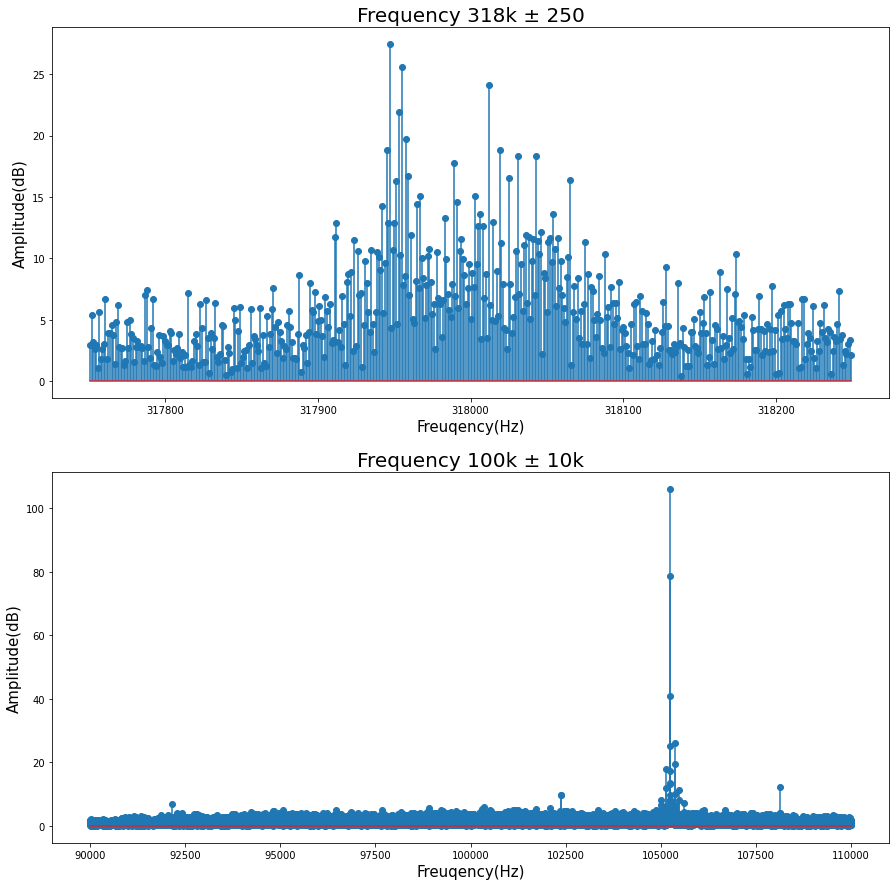

In [6]:
f_318k = frequency[(frequency>317750) & (frequency<318250)]
a_318k = amplitude[(frequency>317750) & (frequency<318250)]

f_100k = frequency[(frequency>100e3-10e3) & (frequency<100e3+10e3)]
a_100k = amplitude[(frequency>100e3-10e3) & (frequency<100e3+10e3)]

fig, axes = plt.subplots(2,1, figsize=(15, 15))

axes[0].stem(f_318k, a_318k)
axes[0].set_title("Frequency 318k ± 250", fontsize=20)
axes[0].set_xlabel("Freuqency(Hz)", fontsize=15)
axes[0].set_ylabel("Amplitude(dB)", fontsize=15)

axes[1].stem(f_100k, a_100k)
axes[1].set_title("Frequency 100k ± 10k", fontsize=20)
axes[1].set_xlabel("Freuqency(Hz)", fontsize=15)
axes[1].set_ylabel("Amplitude(dB)", fontsize=15)

f_318k[np.argmax(a_318k)]
f_100k[np.argmax(a_100k)]

In [7]:
print("318k max amplitude frequency :", f_318k[np.argmax(a_318k)])
print("100k max amplitude frequency :", f_100k[np.argmax(a_100k)])

318k max amplitude frequency : 317947.0
100k max amplitude frequency : 105245.0


##### Bandpassfilter (Butterworth)

이전에 100khz 주변에서 가장 큰 신호 세기를 가지고 있는 주파수만 남기고 다른 신호들을 필터링하기 위해, bandpassfilter를 적용하였다. filtering 된 신호와 원 신호를 같이 plot하여 필터 전후의 결과를 확인한다.

In [8]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
lowcut = 102500.0
highcut = 107500.0

mean = data.mean()
data = data-mean


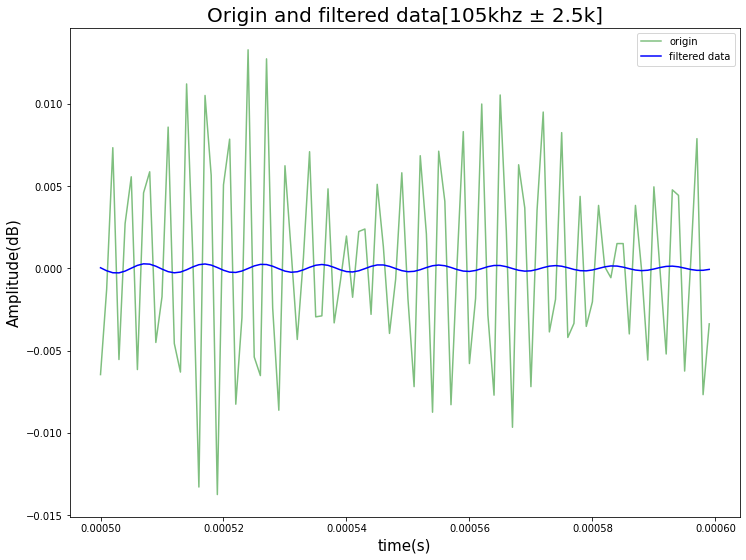

In [10]:
yy = butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
plt.figure(figsize=(12, 9))
plt.plot(time_interval[a:b], data[a:b], 'g', label='origin', alpha=0.5)
plt.plot(time_interval[a:b], yy[a:b], 'b', label='filtered data')
plt.title("Origin and filtered data[105khz ± 2.5k]", fontsize=20)
plt.ylabel("Amplitude(dB)", fontsize=15)
plt.xlabel("time(s)", fontsize=15)
plt.legend()
plt.show()